In [28]:
%pip install numpy
%pip install tensorflow-macos
%pip install networkx
%pip install matplotlib
%pip install pydot
%pip install scipy
%pip install elkai
%pip install bidict

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import numpy as np
import math
import networkx as nx
import scipy
import elkai

In [30]:
from typing import List, Dict, Tuple
from bidict import bidict

In [31]:
# model = ResNet50(weights='imagenet')
# tf.keras.utils.plot_model(model, "resnet.png")

In [32]:
model = InceptionResNetV2(weights='imagenet')
tf.keras.utils.plot_model(model, "inception.png")

In [33]:
def get_previous(model, layer_name):
    inbound = model.get_layer(layer_name).inbound_nodes[0].inbound_layers
    if type(inbound) != list:
        inbound = [inbound]
    return [layer.name for layer in inbound]

# Traverses the model starting from layer_name all the way to start
def traverse(model, layer_name, start, part_name, inpt):
    # On subsequent recursive steps, the new input layer will be defined,
    # so that name needs to be checked in base case
    if (layer_name == start) or (layer_name == part_name):
        return inpt

    output = []
    for n in get_previous(model, layer_name):
        output.append(traverse(model, n, start, part_name, inpt))

    # If the DAG node only has 1 previous connection
    if len(output) == 1:
        output = output[0]

    layer = model.get_layer(layer_name)
    to_next = layer(output)
    return to_next

In [34]:
def construct_model(model, start, end, part_name="part_begin"):
    inpt = keras.Input(tensor=model.get_layer(start).output, name=part_name)
    output = traverse(model, end, start, part_name, inpt)
    part = keras.Model(inputs=model.get_layer(start).output, outputs=output)
    return part

In [35]:
def keras_model_memory_usage_in_bytes(model, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multiplied by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sq_sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sq_sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [36]:
def keras_layer_memory(layer_name, batch_size: int):
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    
    if isinstance(layer_name, tf.keras.Model):
        internal_model_mem_count += keras_model_memory_usage_in_bytes(
            layer_name, batch_size=batch_size
        )
    single_layer_mem = tf.as_dtype(layer_name.dtype or default_dtype).size
    out_shape = layer_name.output_shape
    if isinstance(out_shape, list):
        out_shape = out_shape[0]
    for s in out_shape:
        if s is None:
            continue
        single_layer_mem *= s
    shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in layer_name.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in layer_name.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [37]:
def get_next(model, layer_name):
    outbound = model.get_layer(layer_name).outbound_nodes
    return [node.outbound_layer.name for node in outbound]

In [38]:
# A recursive function used by longest_path. See below
# link for details
# https:#www.geeksforgeeks.org/topological-sorting/
def topological_sort_util(model: keras.Model, v: str):
    global Stack, visited
    visited[v] = True

    # Recur for all the vertices adjacent to this vertex
    # list<AdjListNode>::iterator i
    for i in get_next(model, v):
        if not visited[i]:
            topological_sort_util(model, i)

    # Push current vertex to stack which stores topological
    # sort
    Stack.append(v)

# The function to find longest distances from a given vertex.
# It uses recursive topologicalSortUtil() to get topological
# sorting.
def longest_path(model: keras.Model, s: str):
    global Stack, layer_level, visited
    for l in model.layers:
        visited[l.name] = False
        layer_level[l.name] = -1 # Equal to -infty

    # Call the recursive helper function to store Topological
    # Sort starting from all vertices one by one
    for l in model.layers:
        if not visited[l.name]:
            topological_sort_util(model, l.name)

    # Initialize distances to all vertices as infinite and
    # distance to source as 0
    layer_level[s] = 0
    # Stack.append(1)

    # Process vertices in topological order
    while len(Stack) > 0:

        # Get the next vertex from topological order
        u = Stack.pop()

        # Update distances of all adjacent vertices
        # list<AdjListNode>::iterator i
        if layer_level[u] != -1:
            for i in get_next(model, u):
                if layer_level[i] < layer_level[u] + 1:
                    layer_level[i] = layer_level[u] + 1 # Each edge weighted 1

    # Create array of calculated longest distances to layer
    layers_at_level = [[]] * len(layer_level)
    for l in model.layers:
        if len(layers_at_level[layer_level[l.name]]) == 0:
            layers_at_level[layer_level[l.name]] = []

        layers_at_level[layer_level[l.name]].append(l.name)

    return layers_at_level


Stack = []
visited = {}
layer_level = {}

def find_singletons(model):
    # Model only has 1 input, which is input_names[0]
    name = model.input_names[0]
    # Finding the longest path from the start to every other layer
    levels = longest_path(model, name)
    singletons = []
    for l in range(len(levels)):
        if len(levels[l]) == 1:
            singletons.append(levels[l][0])
    return levels, singletons

levels, singletons = find_singletons(model)
print(singletons)

['input_1', 'conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'max_pooling2d_1', 'conv2d_10', 'batch_normalization_10', 'activation_10', 'mixed_5b', 'conv2d_17', 'batch_normalization_17', 'activation_17', 'block35_1_mixed', 'block35_1_conv', 'block35_1', 'block35_1_ac', 'conv2d_23', 'batch_normalization_23', 'activation_23', 'block35_2_mixed', 'block35_2_conv', 'block35_2', 'block35_2_ac', 'conv2d_29', 'batch_normalization_29', 'activation_29', 'block35_3_mixed', 'block35_3_conv', 'block35_3', 'block35_3_ac', 'conv2d_35', 'batch_normalization_35', 'activation_35', 'block35_4_mixed', 'block35_4_conv', 'block35_4', 'block35_4_ac', 'conv2d_41', 'batch_normalization_41', 'activation_41', 'block35_5_mixed', 'block35_5_conv', 'block35_5', 'block35_5_ac', 'conv2d_47', 'b

In [39]:
def find_all_paths_util(u, d, visited, path, all_paths):
    # If the distance of the current path is greater than the longest path (the "level") to the destination node, we know the destination node can't be a partition point
    if layer_level[u] > layer_level[d]:
        return False
    # Mark the current node as visited and store in path
    visited[u] = True
    path.append(u)

    # If current vertex is same as destination, then print
    # current path[] (because we've found a path from u to d)
    if u == d:
        exists = False
        # See if path already exists in list of paths
        for p in all_paths:
            if p == path:
                exists = True
                break
        
        if not exists:
            all_paths.append(path.copy())
    else:
        # If current vertex is not destination
        # Recur for all the vertices adjacent to this vertex
        for i in get_next(model, u):
            if not visited[i]:
                ret = find_all_paths_util(i, d, visited, path, all_paths)
                if not ret:
                    return False
                
    # Remove current vertex from path[] and mark it as unvisited
    path.pop()
    visited[u] = False
    return True


# Finds all paths from 's' to 'd', and returns false if a there exists a path from s that has a greater "level" than d
def find_all_paths(s, d):
    # Mark all the vertices as not visited
    visited = {}
    for l in model.layers:
        visited[l.name] = False

    # Create an array to store paths
    path = []
    all_paths = []

    # Call the recursive helper function to find all paths
    return find_all_paths_util(s, d, visited, path, all_paths)

In [40]:
def partitions_util(prev, singleton_nodes, partitions):
    # Reached the end of the model and found all the partitions
    if len(singleton_nodes) == 0:
        return partitions
    p = False
    i = -1 # So first i starts at 0
    # Starting from the previous partition point, we iterate through all the subsequent singleton nodes to find the next partition point
    while not p:
        i += 1
        p = find_all_paths(prev, singleton_nodes[i])
    
    partitions.append(singleton_nodes[i])
    return partitions_util(singleton_nodes[i], singleton_nodes[i + 1:], partitions)

def find_partitions(model: keras.Model):
    inpt = model.input_names[0]
    return partitions_util(inpt, find_singletons(model)[1], [])

partition_pts = find_partitions(model)
print(partition_pts)

['input_1', 'conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'max_pooling2d_1', 'mixed_5b', 'block35_1', 'block35_1_ac', 'block35_2', 'block35_2_ac', 'block35_3', 'block35_3_ac', 'block35_4', 'block35_4_ac', 'block35_5', 'block35_5_ac', 'block35_6', 'block35_6_ac', 'block35_7', 'block35_7_ac', 'block35_8', 'block35_8_ac', 'block35_9', 'block35_9_ac', 'block35_10', 'block35_10_ac', 'mixed_6a', 'block17_1', 'block17_1_ac', 'block17_2', 'block17_2_ac', 'block17_3', 'block17_3_ac', 'block17_4', 'block17_4_ac', 'block17_5', 'block17_5_ac', 'block17_6', 'block17_6_ac', 'block17_7', 'block17_7_ac', 'block17_8', 'block17_8_ac', 'block17_9', 'block17_9_ac', 'block17_10', 'block17_10_ac', 'block17_11', 'block17_11_ac', 'block17_12', 'block17_12_ac', 'block17_13', 'block17_

In [41]:
def find_partition_memory(partition_points):
    parts_to_mem = {}
    part_mems = []
    for i in range(1, len(partition_points)):
        # Going backwards along layers within partition to find total memory usage
        start = layer_level[partition_points[i]]
        end = layer_level[partition_points[i - 1]]
        mem = 0
        for j in range(start, end, -1):
            for l in levels[j]:
                layer_mem = keras_layer_memory(model.get_layer(l), 1)
                mem += layer_mem
        parts_to_mem[partition_points[i]] = mem
        part_mems.append(mem)
    return parts_to_mem, part_mems

partition_mem_dict, partition_mems = find_partition_memory(partition_pts)
print(partition_mem_dict)

{'conv2d': 2842592, 'batch_normalization': 2841824, 'activation': 2841728, 'conv2d_1': 2775168, 'batch_normalization_1': 2766048, 'activation_1': 2765952, 'conv2d_2': 5550336, 'batch_normalization_2': 5532096, 'activation_2': 5531904, 'max_pooling2d': 1364224, 'conv2d_3': 1710400, 'batch_normalization_3': 1705520, 'activation_3': 1705280, 'conv2d_4': 4009728, 'batch_normalization_4': 3872064, 'activation_4': 3871488, 'max_pooling2d_1': 940800, 'mixed_5b': 10539248, 'block35_1': 7414608, 'block35_1_ac': 1568000, 'block35_2': 7414608, 'block35_2_ac': 1568000, 'block35_3': 7414608, 'block35_3_ac': 1568000, 'block35_4': 7414608, 'block35_4_ac': 1568000, 'block35_5': 7414608, 'block35_5_ac': 1568000, 'block35_6': 7414608, 'block35_6_ac': 1568000, 'block35_7': 7414608, 'block35_7_ac': 1568000, 'block35_8': 7414608, 'block35_8_ac': 1568000, 'block35_9': 7414608, 'block35_9_ac': 1568000, 'block35_10': 7414608, 'block35_10_ac': 1568000, 'mixed_6a': 14483712, 'block17_1': 6417312, 'block17_1_ac'

In [42]:
def find_partition_transfer_size(partition_points):
    parts_transfer_size_dict = {}
    transfer_sizes = []
    a = []
    for i in range(1, len(partition_points)):
        #print(f"{partition_points[i]}: {len(model.get_layer(partition_points[i]).outbound_nodes)}")
        num_outbound = len(model.get_layer(partition_points[i]).outbound_nodes)

        # Iterate through all elements of shape tuple except first one (which is batch size)
        output_size = 1
        for s in model.get_layer(partition_points[i]).get_output_at(0).get_shape()[1:]:
            output_size *= s
        # All outputs of the model are the same size, the total size will be (output size * num_output_nodes)
        transfer_size = num_outbound * output_size

        parts_transfer_size_dict[partition_points[i]] = transfer_size
        transfer_sizes.append(transfer_size)

    return parts_transfer_size_dict, transfer_sizes

transfer_size_dict, transfer_size_list = find_partition_transfer_size(partition_pts)
print(transfer_size_dict)

{'conv2d': 710432, 'batch_normalization': 710432, 'activation': 710432, 'conv2d_1': 691488, 'batch_normalization_1': 691488, 'activation_1': 691488, 'conv2d_2': 1382976, 'batch_normalization_2': 1382976, 'activation_2': 1382976, 'max_pooling2d': 341056, 'conv2d_3': 426320, 'batch_normalization_3': 426320, 'activation_3': 426320, 'conv2d_4': 967872, 'batch_normalization_4': 967872, 'activation_4': 967872, 'max_pooling2d_1': 940800, 'mixed_5b': 1568000, 'block35_1': 392000, 'block35_1_ac': 1568000, 'block35_2': 392000, 'block35_2_ac': 1568000, 'block35_3': 392000, 'block35_3_ac': 1568000, 'block35_4': 392000, 'block35_4_ac': 1568000, 'block35_5': 392000, 'block35_5_ac': 1568000, 'block35_6': 392000, 'block35_6_ac': 1568000, 'block35_7': 392000, 'block35_7_ac': 1568000, 'block35_8': 392000, 'block35_8_ac': 1568000, 'block35_9': 392000, 'block35_9_ac': 1568000, 'block35_10': 392000, 'block35_10_ac': 1176000, 'mixed_6a': 943296, 'block17_1': 314432, 'block17_1_ac': 943296, 'block17_2': 3144

In [43]:
arr = np.array(transfer_size_list)
m = np.mean(arr)
sq_sum = 0
for z in arr:
    sq_sum += (z - m) ** 2
stdev = math.sqrt(sq_sum / len(arr))
coeff_of_variation = stdev / m
# Coefficient of Variation is less than 1, so it's not that high
print(coeff_of_variation)

0.7017242439455266


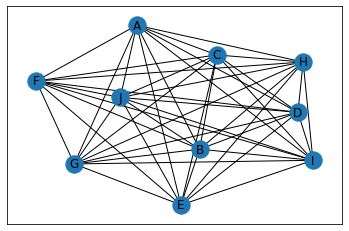

In [56]:
num_nodes = 10
communication_graph = nx.random_geometric_graph([chr(i) for i in range(ord('A'), ord('A') + num_nodes)], 2, dim=3, seed=5)

# Bidict mapping index in distance matrix row/column to name of node
name_to_idx = bidict({chr(i):(i - ord('A')) for i in range(ord('A'), ord('A') + num_nodes)})

weighted_edges = []
for j in communication_graph.edges:
    u = j[0]
    v = j[1]
    w = scipy.spatial.distance.euclidean(communication_graph.nodes[u]["pos"], communication_graph.nodes[v]["pos"])
    weighted_edges.append((u, v, w))
communication_graph.add_weighted_edges_from(weighted_edges)
nx.draw_networkx(communication_graph)

In [57]:
def order_edge_weights(g: nx.Graph):
    edges=sorted(g.edges().data('weight'), key=lambda t: t[2])
    return edges

# Zero/One Cost Matrix as used in http://www.cs.unb.ca/tech-reports/honours-theses/John.LaRusic-4997.pdf
def build_cost_matrix(E, b: int):
    matrix = [[0] * num_nodes] * num_nodes
    for e in E:
        w = 1
        if e[2] <= b:
            w = 0
        matrix[name_to_idx[e[0]]][name_to_idx[e[1]]] = w

    return matrix

# Returns the length of a tour given by an ordered list of vertices
def get_tour_length(t: List[int], dist: List[List]):
    length = 0
    for i in range(len(t) - 1):
        length += dist[t[i]][t[i+1]]
    return length

def btsp_binary_search(g: nx.Graph):
    E = order_edge_weights(g)
    low = 0
    high = len(E)
    best_tour = []
    while low < high:
        median = ((high - low) // 2) + low
        med_cost = E[median][2]
        D = build_cost_matrix(E, med_cost)
        tour = elkai.solve_int_matrix(D)
        length = get_tour_length(tour, D)
        if length == 0:
            high = median
            best_tour = tour
        else:
            low = median + 1

    tour_names = [name_to_idx.inverse[t] for t in best_tour]
    return tour_names

print(btsp_binary_search(communication_graph))

['A', 'F', 'J', 'C', 'E', 'B', 'H', 'D', 'I', 'G']


In [65]:
def partition_model(parts: List[str], part_mems: List[int], part_data_size: List[int], node_capacities: List[int], communication_graph: nx.Graph) -> Dict[str, Tuple[str, str]]:
    min_cap_per_node = node_capacities[0] / len(node_capacities)
    models = []
    prev_partition_point = 0
    for c in range(len(node_capacities)):
        # We've partitioned the model in less physical nodes than we have
        if prev_partition_point > len(part_mems) - 1:
            break
        p = prev_partition_point
        min_data_size = part_data_size[p]
        min_data_size_ind = p
        while sum(part_mems[prev_partition_point : p]) < node_capacities[c]:
            # divide node capacity by number of nodes, and make sure that each node has at least that amount of capacity, to make sure we fit the model into the nodes
            if part_data_size[p] < min_data_size and sum(part_mems[prev_partition_point : p]) > min_cap_per_node:
                min_data_size = part_data_size[p]
                min_data_size_ind = p
            # End of partition points
            if p == len(part_mems) - 1:
                break
            p += 1
        min_data_size_partition_pt = parts[min_data_size_ind + 1]
        models.append((parts[prev_partition_point + 1], min_data_size_partition_pt))

        # The "+1" is so that the next partition starts at the layer after the previous partition
        prev_partition_point = min_data_size_ind + 1

    # The first partition should start from the input layer
    models[0] = (parts[0], models[0][1])
    # The last partition should end with the output layer
    models[-1] = (models[-1][0], parts[-1])

    # If the last partition fits into the node, we know we've partitioned successfully
    if sum(part_mems[parts.index(models[-1][0]):]) <= node_capacities[-1]:
        print("Model successfully partitioned")

    partition_per_node = {}
    node_tour = btsp_binary_search(communication_graph)
    for i in range(len(models)):
        partition_per_node[node_tour[i]] = models[i]
    return partition_per_node

# Homogeneous nodes (in real world, the nodes won't have dramatically different capacities)
nodes = [100 * (1024 ** 2)] * num_nodes
node_partitions = partition_model(partition_pts, partition_mems, transfer_size_list, nodes, communication_graph)
print(node_partitions)

Model successfully partitioned
{'A': ('input_1', 'max_pooling2d'), 'F': ('conv2d_3', 'block35_1'), 'J': ('block35_1_ac', 'block17_1'), 'C': ('block17_1_ac', 'block17_4'), 'E': ('block17_4_ac', 'block17_7'), 'B': ('block17_7_ac', 'block17_10'), 'H': ('block17_10_ac', 'block8_1'), 'D': ('block8_1_ac', 'predictions')}
